# Определение стоимости автомобилей

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель**
Построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Изучение данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd 
import numpy as np
import seaborn as sns
import lightgbm
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# сохраняем датасет в переменную data
data = pd.read_csv('autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**

* `Price` — цена (евро)

In [4]:
# посмотрим количество пропусков
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Есть пропуски в следующих колонках: тип автомобильного кузова (`VehicleType`), тип коробки передач (`Gearbox`), модель автомобиля (`Model`), тип топлива (`FuelType`), была ли в ремонте или нет (`NotRepaired`)

### Заполнение пропусков

In [5]:
# уникальные значения колонки тип топлива
print(data.FuelType.unique())
print(data.VehicleType.unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


Пропущенные значения в данной колонках можно заполнить значением other.

In [6]:
# заполнение пропусков в колонке FuelType и VehicleType
data['FuelType'] = data['FuelType'].fillna('other')
data['VehicleType'] = data['VehicleType'].fillna('other')     
print(data.FuelType.unique(), data.VehicleType.unique(), sep='\n')
data.isna().sum()

['petrol' 'gasoline' 'other' 'lpg' 'hybrid' 'cng' 'electric']
['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon']


DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# уникальное значение Gearbox
data.Gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

Сложно сказать машина автомат или механика, так как одна и таже модель и бред машины может иметь разные коробки передач. Пропуски заменим на 'unkown'

In [8]:
# заполнение пропусков в колонке Gearbox
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data.Gearbox.unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [9]:
# заполнение пропусков в колонке Model
data['Model'] = data['Model'].fillna('unknown')
data.Model.isna().sum()

0

In [10]:
# заполнение пропусков в колонке NotRepaired
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
data.NotRepaired.isna().sum()

0

### Работа с выборосами

In [11]:
# Уникальные значения колонки NumberOfPictures
data['NumberOfPictures'].unique()

array([0])

Удалим колонки, которые не могут влиять на стоимость автомобиля. Например дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, почтовый индекс владельца анкеты (пользователя) и дата последней активности пользователя. Так как в колонке c количество фото автомобиля все значения равны 0, то так же удалим эту колонку.

In [12]:
data_new = data.drop(['DateCrawled', 
                      'RegistrationMonth',
                      'DateCreated', 
                      'PostalCode', 
                      'LastSeen',
                      'NumberOfPictures'], 
                     axis=1).copy()

В уникальных значениях колонки Power есть 0, мощность автомобиля равняться 0 не может, следовательно это некоректные данные. Их число 40225.

In [13]:
data_new['Power'][data_new['Power'] == 0].count()

40225

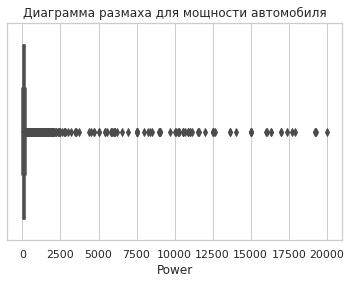

In [14]:
# ящик с усами для значений из колонки мощность автомобиля 
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_new["Power"]).set(title='Диаграмма размаха для мощности автомобиля')

Самый мощный автомобиль имеет окло 2000 л.с., следовательно все значение превышающие 2000 л.с. некорректны. Возможно при заполнении анкеты человек указал неверное число. Мы выяснили, что все анкеты заполнялись в 1970 году. Следовательно мощность автомобилей до 1970 года не могла превышать 1000 л.с.

In [15]:
data_new['Power'][data_new['Power'] > 2000].count()

120

Сумма некорректных значений составляет 40345. Это составляет около 11%. Избавимся от этих значений.

In [16]:
data_new = data_new.query('0 < Power < 2000').copy()

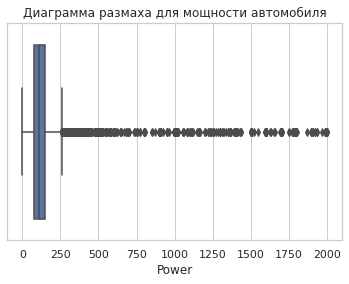

In [17]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_new["Power"]).set(title='Диаграмма размаха для мощности автомобиля')

* Избавились от явных выбросов в колонке с мощность автомобиля, одноко судя по графику, автомобилей с мощностью больше 250 л.с. немного. Оставим значения превышающие 250 л.с. ориентируясь на максимальную мощность автомобиля.

Посмотрим на значения в колонке целевого признака. Стоимость выше 17000 встречается очень редко. Также есть владельцы не указавшие стоимость автомобиля и тогда значение в данной колонке равняется 0. Избавимся от выбросов в целевом признаке.

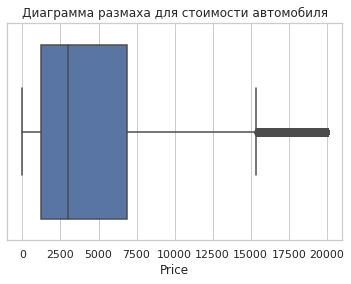

In [18]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_new["Price"]).set(title='Диаграмма размаха для стоимости автомобиля')

In [19]:
# сделаем срез по данным без учета выбросов
data_new = data_new.query('0 < Price < 17000').copy()

* Интересная ситуация с годом регистрации автомобиля, год регистрации автомобиля не может превышать значение 2016 и не может быть меньше 1900. Избавимся от этих выбросов.

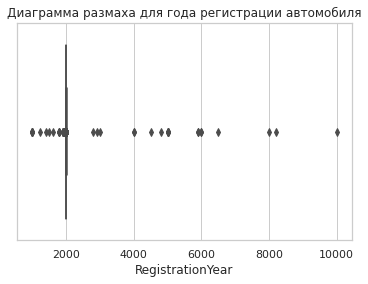

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_new["RegistrationYear"]).set(title='Диаграмма размаха для года регистрации автомобиля')

Посмотрим на дату создания анкет. Для этого изменим тип данных в колонке DateCrawled.

In [21]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
data['DateCrawled'] = data['DateCrawled'].dt.year
data['DateCrawled'].unique()

array([2016])

Все анкеты были созданы в 2016 году. На момент заполнения пользователями анкеты, год регистрации автомобиля не может превышать 2016.

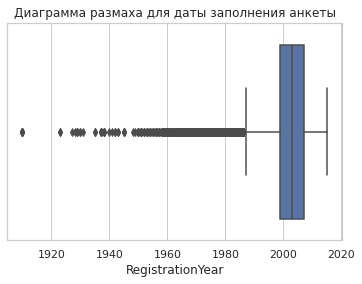

In [22]:
# сделаем срез по данным без учета выбросов
data_new = data_new.query('1900 < RegistrationYear < 2016').copy()
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data_new["RegistrationYear"]).set(title='Диаграмма размаха для даты заполнения анкеты')

## Обучение моделей

### Изучение зависимостей между признаками

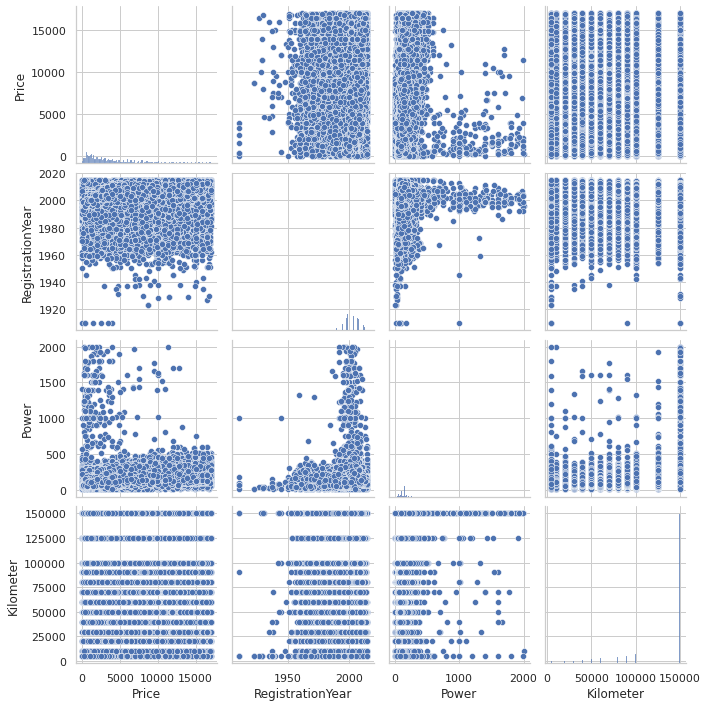

In [23]:
# Посмотрим есть ли корреляция в данных 
print(sns.pairplot(data_new))

AxesSubplot(0.125,0.125;0.62x0.755)


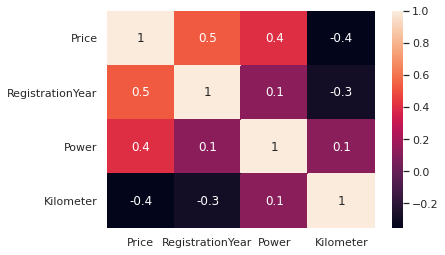

In [24]:
print(sns.heatmap(data_new.corr(),annot = True, fmt = '.1g'))

Зависимость между признаками и целевым признаком отсутствует. Однако, очень слабая корреляция наблюдается между ценой и пробегом автомобиля. Чем больше пробег, тем ниже стоимость автомобиля.

### Подготовка данных для обучения модели

Для преобразования категориальных переменных в численные используем метод One-Hot Encoding.

In [25]:
# воспользуемся техникой OHE для преобразования категориальных переменных
data_new_ohe = pd.get_dummies(data_new, drop_first=True)
data_new_ohe.head(5)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# делим датасет на общие признаки и целевой
features = data_new_ohe.drop('Price', axis=1)
target = data_new_ohe['Price']

Изначально разделим исходный датасет на три выборки обучающую, валидационную, тестовую. В соотношении 3:1:1.

In [27]:
features_train, features_vt, target_train, target_vt  = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test  = train_test_split(
    features_vt, target_vt, test_size=0.5, random_state=12345)
    
print(f'Тренировочная выборка: {features_train.shape}')
print(f'Валидационная выборка: {features_valid.shape}')
print(f'Тестовая выборка: {features_test.shape}')    

Тренировочная выборка: (169672, 308)
Валидационная выборка: (56557, 308)
Тестовая выборка: (56558, 308)


Произведем маштабирование численных признаков.

In [28]:
# маштабирование признаков 
pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear',
           'Power',
           'Kilometer',
           'VehicleType_convertible',
          ]
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проведем обучение и подбор параметров для следующих моделей:

* LinearRegression
* ExtraTreesRegressor
* RandomForestRegressor
* CatBoostRegressor 
* LGBMRegressor

### Модель CatBoostRegressor

In [29]:
model_cat = CatBoostRegressor(loss_function='RMSE')
parametrs = {'iterations': range(10, 1200),
            'learning_rate': np.arange(0.01, 0.2, 0.01),
            'max_depth': range(1, 10)}

model_cat = RandomizedSearchCV(model_cat, parametrs, cv=3)
model_cat.fit(features_train, target_train, verbose=100)
print(model_cat.best_params_)

predictions = model_cat.predict(features_valid)
RMSE_cat = mean_squared_error(target_valid, predictions, squared=False)
print(RMSE_cat)

0:	learn: 3968.6916250	total: 60.5ms	remaining: 36.2s
100:	learn: 2053.6375615	total: 1.09s	remaining: 5.37s
200:	learn: 1888.1368307	total: 2.09s	remaining: 4.15s
300:	learn: 1814.3450992	total: 3.1s	remaining: 3.06s
400:	learn: 1773.2739693	total: 4.08s	remaining: 2.02s
500:	learn: 1746.5288515	total: 5.16s	remaining: 1.01s
598:	learn: 1726.5259339	total: 6.18s	remaining: 0us
0:	learn: 3985.6083384	total: 9.46ms	remaining: 5.66s
100:	learn: 2065.0054591	total: 1.01s	remaining: 4.99s
200:	learn: 1900.7057334	total: 2.01s	remaining: 3.98s
300:	learn: 1826.6379504	total: 3.01s	remaining: 2.98s
400:	learn: 1784.7307672	total: 4s	remaining: 1.98s
500:	learn: 1757.4756428	total: 4.98s	remaining: 975ms
598:	learn: 1735.3356409	total: 5.9s	remaining: 0us
0:	learn: 3977.5469998	total: 9.68ms	remaining: 5.79s
100:	learn: 2058.7139039	total: 1.11s	remaining: 5.46s
200:	learn: 1896.3064272	total: 2.2s	remaining: 4.36s
300:	learn: 1822.4154529	total: 3.26s	remaining: 3.22s
400:	learn: 1779.758401

### Модели ExtraTreesRegressor, RandomForestRegressor

In [30]:
models = [RandomForestRegressor(random_state=12345), 
          ExtraTreesRegressor(random_state=12345)]
RMSE_tree_list = []

for i in models:
    params = {'n_estimators': range (1, 50),
          'max_depth': range (1, 10)}
    model_tree = RandomizedSearchCV(i, params)
    model_tree.fit(features_train, target_train)
    print(model_tree.best_params_)

    predictions = model_tree.predict(features_valid)
    RMSE_tree = mean_squared_error(target_valid, predictions, squared=False)
    RMSE_tree_list.append(RMSE_tree)
    print(RMSE_tree)

{'n_estimators': 27, 'max_depth': 9}
1754.1034728784184
{'n_estimators': 12, 'max_depth': 9}
1989.9944416661097


### Модель LinearRegression

In [31]:
# используем кросс-валидацию
model_lr = LinearRegression()
cross_val_score = cross_val_score(model_lr, 
                                  features_train, 
                                  target_train, 
                                  scoring = ('neg_root_mean_squared_error'),
                                  cv=5).mean()
print(cross_val_score)

-2398.253088266987


### Модель LGBMRegressor

In [33]:
model = LGBMRegressor()
parametrs = {'max_depth': range (1,15),
             'n_estimators ': range (1, 100, 2),
             'learning_rate': np.arange (0.01,0.2)}
model = RandomizedSearchCV(model, parametrs, cv=3)
model.fit(features_train, target_train)
print(model.best_params_)

predictions = model.predict(features_valid)
RMSE_lgbmr = mean_squared_error(target_valid, predictions, squared=False)
print(RMSE_lgbmr)

[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 81
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 81
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 81
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 61
[LightGBM] [Warning] 

### Проверка моделей на тестовой выборке

Объединим валидационную и обучающую выборку.

In [34]:
feature_train_wider = pd.concat([features_train, features_valid])
target_train_wider = pd.concat([target_train, target_valid])

In [35]:
results = pd.DataFrame({'Regresson' : [],
                        'Train RMSE score' : [], 
                        'Test RMSE score' : [], 
                        'Time_study' : [],
                        'Time_prediction' : []})

In [36]:
# Модель линейной регрессии 
start = time.time()
model_lr_2 = LinearRegression()
model_lr_2.fit(feature_train_wider, target_train_wider)

end_study = time.time() - start
start = time.time()

prediction = model_lr_2.predict(features_test)

RMSE_test = mean_squared_error(target_test, prediction, squared=False)


finish = time.time() - start
print(RMSE_test)
results = results.append({'Regresson' : 'LinearRegression', 
                       'Train RMSE score' : cross_val_score, 
                       'Test RMSE score' : RMSE_test, 
                       'Time_study' : end_study,
                       'Time_prediction' : finish}, ignore_index=True)

2421.838100945135


In [37]:
# градиентный бустинг
start = time.time()

model = LGBMRegressor(n_estimators = 77, max_depth = 13, learning_rate = 0.01)
model.fit(feature_train_wider, target_train_wider)

end_study = time.time() - start
start = time.time()

predictions = model.predict(features_test)

RMSE_test_lgbmr = mean_squared_error(target_test, predictions, squared=False)
finish = time.time()-start

print(RMSE_test_lgbmr)
results = results.append({'Regresson' : 'LGBMRegressor', 
                       'Train RMSE score' : RMSE_lgbmr, 
                       'Test RMSE score' : RMSE_test_lgbmr, 
                       'Time_study' : end_study,
                       'Time_prediction' : finish}, ignore_index=True)

2618.9845271314675


In [38]:
# модель случаного леса
start = time.time()

model = RandomForestRegressor(n_estimators = 15, max_depth = 9)
model.fit(feature_train_wider, target_train_wider)

end_study = time.time() - start
start = time.time()

predictions = model.predict(features_test)

RMSE_test_tree = mean_squared_error(target_test, predictions, squared=False)
finish = time.time() - start

print(RMSE_test_tree)
results = results.append({'Regresson' : 'RandomForestRegressor', 
                       'Train RMSE score' : RMSE_tree_list[0], 
                       'Test RMSE score' : RMSE_test_tree, 
                       'Time_study' : end_study,
                       'Time_prediction' : finish}, ignore_index=True)

1784.9777682497481


In [39]:
# модель ExtraTreesRegressor
start = time.time()

model = ExtraTreesRegressor(n_estimators = 12, max_depth = 9)
model.fit(feature_train_wider, target_train_wider)

end_study = time.time() - start
start = time.time()

predictions = model.predict(features_test)

RMSE_test_tree_2 = mean_squared_error(target_test, predictions, squared=False)
finish = time.time() - start

print(RMSE_test_tree_2)
results = results.append({'Regresson' : 'ExtraTreesRegressor', 
                       'Train RMSE score' : RMSE_tree_list[1], 
                       'Test RMSE score' : RMSE_test_tree_2, 
                       'Time_study' : end_study,
                       'Time_prediction' : finish}, ignore_index=True)

2056.8935853542407


In [40]:
# градиентный бустинг
start = time.time()
model_cat = CatBoostRegressor(loss_function='RMSE', iterations =648, learning_rate =0.15, max_depth= 7)

model_cat.fit(feature_train_wider, target_train_wider, verbose=100)

end_study = time.time() - start
start = time.time()

predictions = model_cat.predict(features_test)
RMSE_test_cat = mean_squared_error(target_test, predictions, squared=False)

finish = time.time() - start
print(RMSE_test_cat)


results = results.append({'Regresson' : 'CatBoostRegressor', 
                       'Train RMSE score' : RMSE_cat, 
                       'Test RMSE score' : RMSE_test_cat, 
                       'Time_study' : end_study,
                       'Time_prediction' : finish}, ignore_index=True )

0:	learn: 3603.4198981	total: 33.1ms	remaining: 34.6s
100:	learn: 1548.3627100	total: 3.12s	remaining: 29.2s
200:	learn: 1478.0428368	total: 5.98s	remaining: 25.1s
300:	learn: 1439.4056654	total: 9.12s	remaining: 22.5s
400:	learn: 1414.3935031	total: 11.8s	remaining: 18.9s
500:	learn: 1394.5067564	total: 14.6s	remaining: 15.9s
600:	learn: 1378.5565132	total: 17.4s	remaining: 12.9s
700:	learn: 1365.1987592	total: 20.4s	remaining: 10s
800:	learn: 1353.4138388	total: 23.2s	remaining: 7.06s
900:	learn: 1343.4161107	total: 25.9s	remaining: 4.14s
1000:	learn: 1334.4512894	total: 28.8s	remaining: 1.27s
1044:	learn: 1330.8501231	total: 30s	remaining: 0us
1438.2628910719554


## Анализ моделей

Выведем итоговую таблицу с характеристиками моделей.

In [41]:
results

,Regresson,Train RMSE score,Test RMSE score,Time_study,Time_prediction
0,LinearRegression,-2398.253088,2421.838101,18.257565,0.194064
1,LGBMRegressor,2381.563821,2618.984527,6.706796,0.501117
2,RandomForestRegressor,1754.103473,1784.977768,36.082308,0.168516
3,ExtraTreesRegressor,1989.994442,2056.893585,43.933745,0.146245
4,CatBoostRegressor,1420.717731,1438.262891,32.507842,0.116138


# Вывод 

На тестовой выборке лучшего значения метрики RMSE удалось достичь с использованием градиентного бустинга CatBoostRegressor - 1438.27. А время обчуния модели - 32.5 с., время предсказания - 0.12 с.
Наилучшее время обучения модели у модели с градиентным бустингом библиотеки LightGBM - 6.71 с. Но у данной модели самое большое время предсказания - 0.5 с.

Из предложенных моделей CatBoostRegressor модель обладает лучшим соотношением скорости обучения, предасказания и качеством метрики. 

Данные модели хорошо подходят для предсказания стоимости автомобиля.